# Multiproduct Linear Monopolist (Schmalensee)

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from math import sqrt, ceil
from timeit import default_timer as timer
from datetime import timedelta
import itertools
import sys
sys.path.append('..')
from modules import LinearMonopolist

## Single resolution

model id = LinearMonopolist_N100_2024-04-11_13-32-56


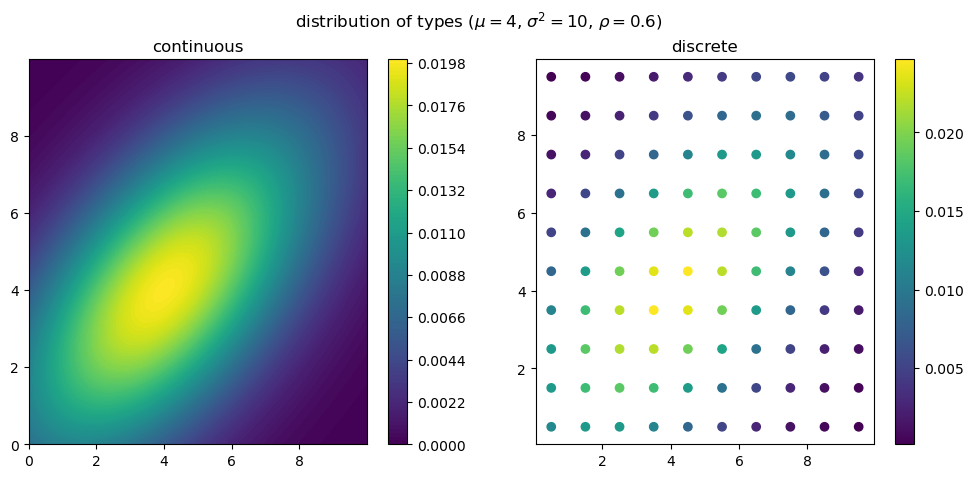

In [2]:
n0, n1 = 10, 10
t0, t1 =  np.linspace(0, 10, num=n0+1, dtype=np.float32), np.linspace(0, 10, num=n1+1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0 = (t0[1:]+t0[:-1])/2 ; theta1 = (t1[1:]+t1[:-1])/2
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1] # number of types

mu = 4; sigma2 = 10; rho = 0.6
distribution = multivariate_normal(mu*np.array([1, 1]), sigma2*np.array([[1, rho], [rho,1]]))
cd = distribution.cdf(np.dstack(np.meshgrid(t0,t1)))
f = cd[1:,1:] + cd[:-1,:-1] - cd[1:,:-1] - cd[:-1,1:]
f = f.flatten() /  np.sum(f) # weights in the distribution

### Model parameters setting
param = {'substituable':False, 'mu':mu, 'simga2':sigma2, 'rho':rho}   # False for indivisible goods (constraints = cube), True for substituable goods (constraints = simplex)

### Objects
model = LinearMonopolist(theta, f, param)

fig, axs = plt.subplots(1,2, figsize=(12,5))
c0, c1 = np.mgrid[np.min(t0):np.max(t0):0.01, np.min(t1):np.max(t1):0.01]
ctypes = axs[0].contourf(c0, c1, distribution.pdf(np.dstack((c0, c1))), 100)
_ = fig.colorbar(ctypes)
_ = axs[0].set_title('continuous')
dtypes = axs[1].scatter(theta0, theta1, c=f)
_ = fig.colorbar(dtypes)
_ = axs[1].set_title('discrete')
_ = fig.suptitle(rf'distribution of types ($\mu=${mu}, $\sigma^2=${sigma2}, $\rho=${rho})')

In [3]:
# path = 'results/Schmalensee/'+model.id+'_distribution'
# fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

In [4]:
kmax = ceil(sqrt(N))+1
df_prices = pd.DataFrame(columns=['mu', 'sigma2', 'rho', 'p', 'b', 'convergence', 'deterministic'])

print(f'mu={mu}, sigma2={sigma2}, rho={rho}\n')

# t_start = timer()
model.local(); k = 0; test = False
while k < kmax and np.any(test==False):
    k += 1
    print(f'OPTIMIZATION {k}: {len(model.indices)} IC constraints')
    model.solve(warmstart=True, it_max = 1e4, stepratio=0.1, log=1) # path='results/'+model.id) #sqrt(len(model.indices)) #len(model.indices)
    # model.residuals()
    print(f'IC constraints: {len(model.IC_binding)} binding, {len(model.IC_violated)} violated\n')
    # model.indices = sorted(set(model.indices).union(model.IC_violated))
    model.indices = sorted(set(model.indices).union(set(model.IC_violated).intersection(model.ind_local(k*ceil(sqrt(N))))))
    model.local(model.indices)
    test = np.array([model.converged, len(model.IC_violated)==0])
# elapsed = timer() - t_start
# print(f'elapsed time = {str(timedelta(seconds=elapsed))}')
if model.converged == False:
    k += 1
    print(f'OPTIMIZATION {k}: {len(model.indices)} IC constraints')
    model.solve(warmstart=True, stepratio=0.1, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True,)
    print('\n')

model.output(log=0)
prices = np.unique(model.p.round(6))
df_prices.loc[len(df_prices)] = [mu, sigma2, rho,  prices[1], prices[-1], model.converged, len(prices)==3]
print(f'nb of optimization = {k}, final convergence = {model.converged}, deterministic solution = {len(prices)==3}\n')

# model.solve(warmstart=True, stepratio=0.5, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True,) #path='results/'+model.id
# model.residuals(title='residuals')

mu=4, sigma2=10, rho=0.6

OPTIMIZATION 1: 180 IC constraints
convergence = True, iterations = 110, elapsed time = 0:00:00.388364
primal residual = 9.28e-02 tol, dual residual = 3.09e-01 tol
primal-dual gap = -2.79e-04, optimal value - current value < -5.41e-05 optimal value
IC constraints: 180 binding, 0 violated



AttributeError: 'LinearMonopolist' object has no attribute 'converged'

In [69]:
# model.solve(warmstart=True, stepratio=10, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True,) 
# model.residuals(title='residuals')

In [122]:
df_prices

,mu,sigma2,rho,p,b,convergence,deterministic
0,4,10,0.6,4.5,8.0,True,True


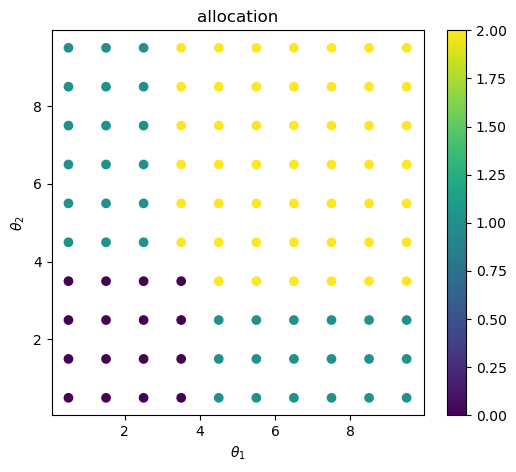

In [4]:
model.display(model.y[:N]+model.y[N:], title='allocation', figsize=(6,5))

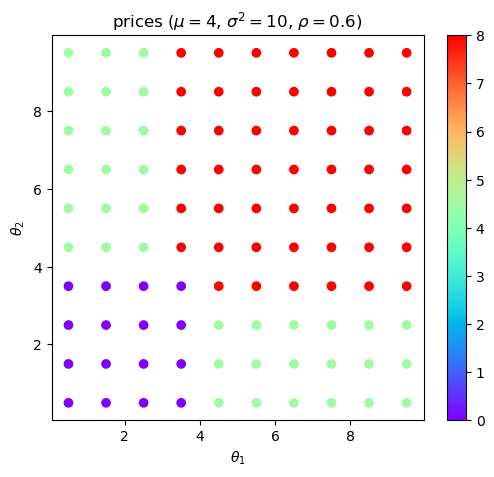

In [5]:
model.display(model.p, title=rf'prices ($\mu=${mu}, $\sigma^2=${sigma2}, $\rho=${rho})', figsize=(6,5), cmap='rainbow',) # path = 'results/Schmalensee/'+model.id+'_prices')

In [129]:
# path = 'results/Schmalensee/'+model.id+'_prices'
# fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

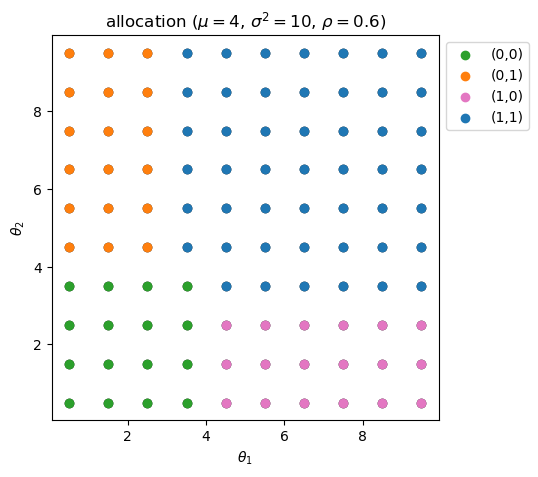

In [6]:
atol = 1e-6
y0_0 = np.isclose(model.y[:model.N],0, atol=atol)
y0_1 = np.isclose(model.y[:model.N],1, atol=atol, rtol=0)
y1_0 = np.isclose(model.y[model.N:],0, atol=atol)
y1_1 = np.isclose(model.y[model.N:],1, atol=atol, rtol=0)

y_00 = np.flatnonzero(np.logical_and(y0_0, y1_0))
y_01 = np.flatnonzero(np.logical_and(y0_0, y1_1))
y_10 = np.flatnonzero(np.logical_and(y0_1, y1_0))
y_11 = np.flatnonzero(np.logical_and(y0_1, y1_1))

fig, ax = plt.subplots(figsize=(5,5))
_ = ax.scatter(theta[0], theta[1], facecolors='w',edgecolors='k')
_ = ax.scatter(theta[0, y_00], theta[1, y_00], c='tab:green', label='(0,0)')
_ = ax.scatter(theta[0, y_01], theta[1, y_01], c='tab:orange', label='(0,1)')
_ = ax.scatter(theta[0, y_10], theta[1, y_10], c='tab:pink', label='(1,0)')
_ = ax.scatter(theta[0, y_11], theta[1, y_11], c='tab:blue', label='(1,1)')
_ = ax.legend(bbox_to_anchor=(1, 1),loc='upper left') #bbox_to_anchor=(0., -.13, 1., .1), loc='lower left', ncols=4, mode="expand", borderaxespad=0.) #(bbox_to_anchor=(1.02, 1.), loc='lower right')
_ = ax.set_title(rf'allocation ($\mu=${mu}, $\sigma^2=${sigma2}, $\rho=${rho})')
_ = ax.set_xlabel(r'$\theta_1$'); _ = ax.set_ylabel(r'$\theta_2$')
# _ = ax.set_title('allocation')


In [127]:
# path = 'results/Schmalensee/'+model.id+'_allocation'
# fig.savefig(path, bbox_inches="tight", pad_inches=0.05)

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(13,5),) # subplot_kw=dict(aspect='equal',))
# item1 = axs[0].scatter(theta[0], theta[1], c = model.y[:model.N], cmap='rainbow')
# _ = fig.colorbar(item1)
# _ = axs[0].set_title('probability of allocating item 1')
# item2 = axs[1].scatter(theta[0], theta[1], c = model.y[model.N:], cmap='rainbow')
# _ = fig.colorbar(item2)
# _ = axs[1].set_title('probability of allocating item 2')
# # _ = fig.suptitle(f'c = {c}')

In [ ]:
model.range(title='Product range', ) #path='results/'+model.id+'_products')

## Multiple resolutions

In [5]:
n0, n1 = 10, 10
t0, t1 =  np.linspace(0, 10, num=n0+1, dtype=np.float32), np.linspace(0, 10, num=n1+1, dtype=np.float32)  #  [1, 1.5, 3], [0, 0.5, 1]
theta0 = (t0[1:]+t0[:-1])/2 ; theta1 = (t1[1:]+t1[:-1])/2
theta0, theta1 = np.meshgrid(theta0,theta1)
theta = np.stack((theta0.flatten(), theta1.flatten())); N = theta.shape[-1] # number of types

kmax = ceil(sqrt(N))+1
df_prices = pd.DataFrame(columns=['mu', 'sigma2', 'rho', 'p', 'b', 'convergence', 'deterministic', 'model id'])

sigma2 = 10
for mu, rho in itertools.product(np.linspace(2, 8, num=61),np.linspace(0, 0.9, num=91)): # num=7 x num=10 or num=61 x num=91
    print(f'mu={mu}, sigma2={sigma2}, rho={rho}')

    distribution = multivariate_normal(mu*np.array([1, 1]), sigma2*np.array([[1, rho], [rho,1]]))
    cd = distribution.cdf(np.dstack(np.meshgrid(t0,t1)))
    f = cd[1:,1:] + cd[:-1,:-1] - cd[1:,:-1] - cd[:-1,1:]
    f = f.flatten() /  np.sum(f) # weights in the distribution

    ### Model parameters setting
    param = {'substituable':False, 'mu':mu, 'simga2':sigma2, 'rho':rho}   # False for indivisible goods (constraints = cube), True for substituable goods (constraints = simplex)

    ### Objects
    model = LinearMonopolist(theta, f, param)
    
    ### Resolution
    # t_start = timer()
    model.local(); k = 0; test = False
    while k < kmax and np.any(test==False):
        k += 1
        # print(f'OPTIMIZATION {k}: {len(model.indices)} IC constraints')
        model.solve(warmstart=True, it_max = 1e4, stepratio=0.1, log=0, ) #path='results/Schmalensee/'+model.id) #sqrt(len(model.indices)) #len(model.indices)
        # model.residuals()
        # print(f'IC constraints: {len(model.IC_binding)} binding, {len(model.IC_violated)} violated\n')
        # model.indices = sorted(set(model.indices).union(model.IC_violated))
        model.indices = sorted(set(model.indices).union(set(model.IC_violated).intersection(model.ind_local(k*ceil(sqrt(N))))))
        model.local(model.indices)
        test = np.array([model.converged, len(model.IC_violated)==0])
    # elapsed = timer() - t_start
    # print(f'elapsed time = {str(timedelta(seconds=elapsed))}')
    if model.converged == False:
        k +=1
        model.solve(warmstart=True, stepratio=0.1, it_max=1e5, tol_primal=1e-6, tol_dual=1e-6, scale=True, log=0) 

    model.output(log=0,) # path='results/Schmalensee/'+model.id)
    prices = np.unique(model.p.round(6))
    df_prices.loc[len(df_prices)] = [mu, sigma2, rho,  prices[1], prices[-1], model.converged, len(prices)==3, model.id]
    print(f'nb of optimization = {k}, final convergence = {model.converged}, deterministic solution = {len(prices)==3}\n')

# df_prices.loc[:,['mu', 'rho', 'p', 'b']]

path = 'results/Schmalensee/prices_N'+str(model.N)
with pd.ExcelWriter(path+'.xlsx') as writer:  
                df_prices.round(3).to_excel(writer, sheet_name='prices')
                
df_prices

mu=2.0, sigma2=10, rho=0.0
model id = LinearMonopolist_N100_2024-04-11_13-33-07
nb of optimization = 1, final convergence = True, deterministic solution = True

mu=2.0, sigma2=10, rho=0.01
model id = LinearMonopolist_N100_2024-04-11_13-33-07
nb of optimization = 1, final convergence = True, deterministic solution = True

mu=2.0, sigma2=10, rho=0.02
model id = LinearMonopolist_N100_2024-04-11_13-33-08
nb of optimization = 1, final convergence = True, deterministic solution = True

mu=2.0, sigma2=10, rho=0.03
model id = LinearMonopolist_N100_2024-04-11_13-33-08
nb of optimization = 1, final convergence = True, deterministic solution = True

mu=2.0, sigma2=10, rho=0.04
model id = LinearMonopolist_N100_2024-04-11_13-33-08
nb of optimization = 1, final convergence = True, deterministic solution = True

mu=2.0, sigma2=10, rho=0.05
model id = LinearMonopolist_N100_2024-04-11_13-33-09
nb of optimization = 1, final convergence = True, deterministic solution = True

mu=2.0, sigma2=10, rho=0.06
m

ModuleNotFoundError: No module named 'openpyxl'

In [6]:
path = 'results/Schmalensee/prices_N'+str(model.N)
with pd.ExcelWriter(path+'.xlsx') as writer:  
                df_prices.round(3).to_excel(writer, sheet_name='prices')
                
df_prices

,mu,sigma2,rho,p,b,convergence,deterministic,model id
0,2.0,10,0.00,4.5,6.0,True,True,LinearMonopolist_N100_2024-04-11_13-33-07
1,2.0,10,0.01,4.5,6.0,True,True,LinearMonopolist_N100_2024-04-11_13-33-07
2,2.0,10,0.02,4.5,6.0,True,True,LinearMonopolist_N100_2024-04-11_13-33-08
3,2.0,10,0.03,4.5,6.0,True,True,LinearMonopolist_N100_2024-04-11_13-33-08
4,2.0,10,0.04,4.5,6.0,True,True,LinearMonopolist_N100_2024-04-11_13-33-08
...,...,...,...,...,...,...,...,...
5546,8.0,10,0.86,5.5,11.0,True,True,LinearMonopolist_N100_2024-04-12_05-11-58
5547,8.0,10,0.87,5.5,11.0,True,True,LinearMonopolist_N100_2024-04-12_05-28-12
5548,8.0,10,0.88,5.5,11.0,True,True,LinearMonopolist_N100_2024-04-12_05-28-28
5549,8.0,10,0.89,5.5,11.0,True,True,LinearMonopolist_N100_2024-04-12_05-28-45


In [ ]:
# path = 'results/Schmalensee/prices_N'+str(model.N)
# with pd.ExcelWriter(path+'.xlsx') as writer:  
#                 df_prices.round(3).to_excel(writer, sheet_name='prices')
# with pd.option_context(#'display.max_rows', None,
#                         'display.max_columns', None,
#                         'display.precision', 3,):
#         print(df_prices)

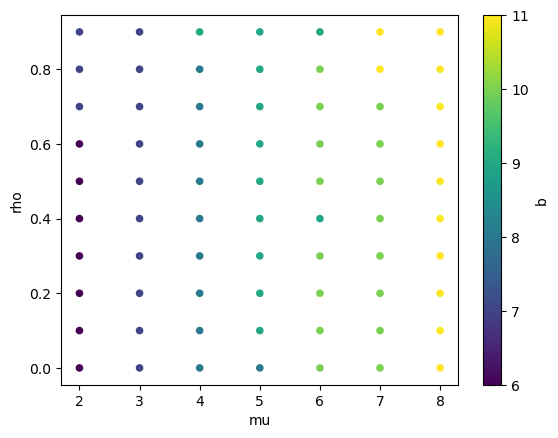

In [115]:
_ = df_prices.plot(kind='scatter', x='mu', y='rho', c='b')

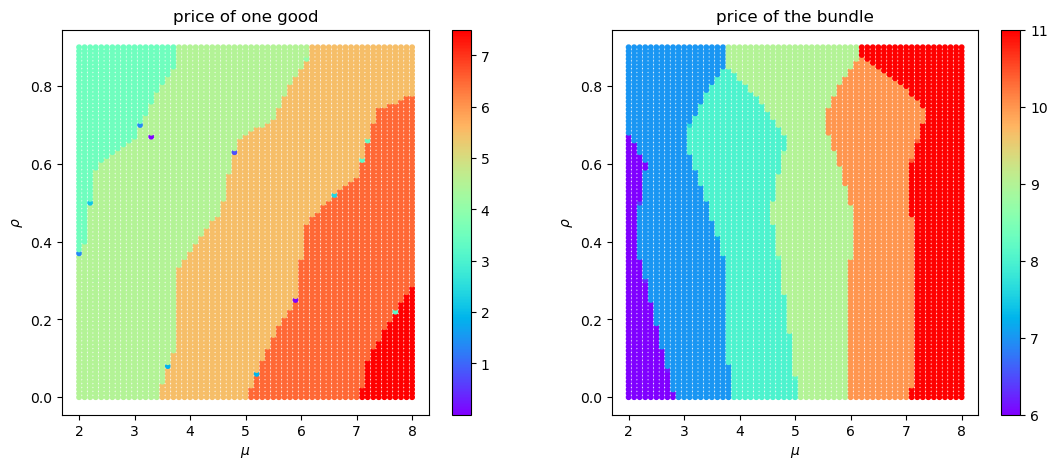

In [9]:
fig, axs = plt.subplots(1,2, figsize=(13,5),) # subplot_kw=dict(aspect='equal',))
item1 = axs[0].scatter(df_prices['mu'],df_prices['rho'], c = df_prices['p'], s=10, cmap='rainbow')
_ = fig.colorbar(item1)
_ = axs[0].set_title('price of one good')
_ = axs[0].set_xlabel(r'$\mu$'); _ = axs[0].set_ylabel(r'$\rho$')
item2 = axs[1].scatter(df_prices['mu'],df_prices['rho'], c = df_prices['b'], s=10, cmap='rainbow')
_ = fig.colorbar(item2)
_ = axs[1].set_title('price of the bundle')
_ = axs[1].set_xlabel(r'$\mu$'); _ = axs[1].set_ylabel(r'$\rho$')
# _ = fig.suptitle(f'c = {c}')


In [11]:
path = 'results/Schmalensee/prices_N'+str(model.N)+'_v2'
fig.savefig(path, bbox_inches="tight", pad_inches=0.05)